In [1]:
import os
import sys
import json
import datetime
import numpy as np
import skimage.draw
import cv2
import random
import math
import re
import time
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
from mrcnn.visualize import display_instances
import mrcnn.model as modellib
from mrcnn.model import log
from mrcnn.config import Config
from mrcnn import model as modellib, utils
import utils_1
import MyUtils
import Paths

Using TensorFlow backend.


In [2]:
Path=Paths.ProjectPath()

In [3]:
wt_path=os.path.join(Path.MRCNN_Trained_Weights_Path,"mask_rcnn_object_0050.h5")


In [4]:
class CustomConfig(Config):
    NAME="object"
    NUM_CLASSES = 1+1
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    STEPS_PER_EPOCH=150
    DETECTION_MIN_CONFIDENCE=0.0
    # DETECTION_NMS_THRESHOLD=0.7
    # RPN_NMS_THRESHOLD=0.3
    LEARNING_RATE=0.0005

In [5]:
class CustomDataset(utils.Dataset):
    def load_custom(self,DSPath,subset):
        self.add_class("object",1,"Grapes")
        # self.add_class("object",2,"CFR Grapes")
        # self.add_class("object",3,"CSV Grapes")
        # self.add_class("object",4,"SVB Grapes")
        # self.add_class("object",5,"SYH Grapes")
        
        data=json.load(open(os.path.join(DSPath,"MRCNN_DS.json")))
        assert subset in ['train','test']
        dataset=data[subset]
        ImgPath=os.path.join(DSPath,"Images")
        NPZPath=os.path.join(DSPath,"NPZFiles")
        TextPath=os.path.join(DSPath,"TextFiles")
        for file in dataset:
            imgfile=file[:-3]+"jpg"
            imgpath=os.path.join(ImgPath,imgfile)
            npzpath=os.path.join(NPZPath,file)
            textpath=os.path.join(TextPath,file[:-3]+"txt")
            img=cv2.imread(imgpath)
            height,width=img.shape[:2]
            self.add_image(source="object",image_id=imgfile,path=imgpath, height=height,width=width,npzfile=npzpath,textfile=textpath,filename=file)

    def yolo_to_unnormalized_box(box_line, image_width, image_height):
        yolo_box=list(map(float,box_line.split(" ")))
        boxClass, center_x, center_y, width, height = yolo_box
 
        # Convert normalized coordinates to original image coordinates
        x_center = int(center_x * image_width)
        y_center = int(center_y * image_height)
        box_width = int(width * image_width)
        box_height = int(height * image_height)

        # Calculate xmin, xmax, ymin, ymax
        x_min = x_center - box_width // 2
        y_min = y_center - box_height // 2
        x_max = x_min + box_width
        y_max = y_min + box_height

        return x_min, x_max, y_min, y_max
    
    def load_mask(self, image_id):
        image_info = self.image_info[image_id]
        if image_info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)
        
        # classes={"CDY":1,"CFR":2,"CSV":3,"SVB":4,"SYH":5}
        # filename=image_info['filename']
        # class_num=classes[filename[:3]]
        npzfile=np.load(image_info['npzfile'])
        
        masks=npzfile['arr_0']
        # masks=masks.astype(np.uint8)
        num_masks=masks.shape
        num_masks=num_masks[-1]
        class_ids=np.ones(num_masks,dtype=np.int32)
        # class_ids=class_ids*class_num
        return masks,class_ids
    
    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "object":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

In [6]:
TEST_MODE = "inference"
def get_ax(rows=1, cols=1, size=16):
  """Return a Matplotlib Axes array to be used in all visualizations in the notebook.  Provide a central point to control graph sizes. Adjust the size attribute to control how big to render images"""
  _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
  return ax

In [7]:
dataset = CustomDataset()
dataset.load_custom(Path.DatasetPath, "test")
dataset.prepare()
print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

Images: 41
Classes: ['BG', 'Grapes']


In [8]:
config = CustomConfig()
model = modellib.MaskRCNN(mode="inference", model_dir=Path.MRCNN_Training_Logs_Path, config=config)







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.


In [9]:
print("Loading weights ", wt_path)
model.load_weights(wt_path, by_name=True)

Loading weights  E:\vsc2.0\GitHub\Grape_instance_segementation_and_masking\MRCNNTrainingLogs\MRCNNTrainedWeights\mask_rcnn_object_0050.h5








Images: 41
Classes: ['BG', 'Grapes']
Processing 1 images
image                    shape: (1365, 2048, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 2048.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
[{'rois': array([[ 837, 1886, 1105, 2037],
       [ 787,  242, 1117,  406],
       [ 560,  613,  899,  824],
       [ 540, 1562,  997, 1719],
       [ 713, 1771, 1071, 1893],
       [ 551,    2, 1075,  126],
       [  90, 1393,  428, 1547],
       [ 678, 1672,  824, 1787],
       [ 922,  812, 1114,  958],
       [ 717,   93, 1044,  267],
       [ 558, 1475,  838, 1582],
       [ 788,  791,  949,  946],
       [ 130, 1499,  327, 1590]]), 'class_ids': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), 'scores': array([0.9999994 , 0.99999905, 0.9999969 , 0.9999

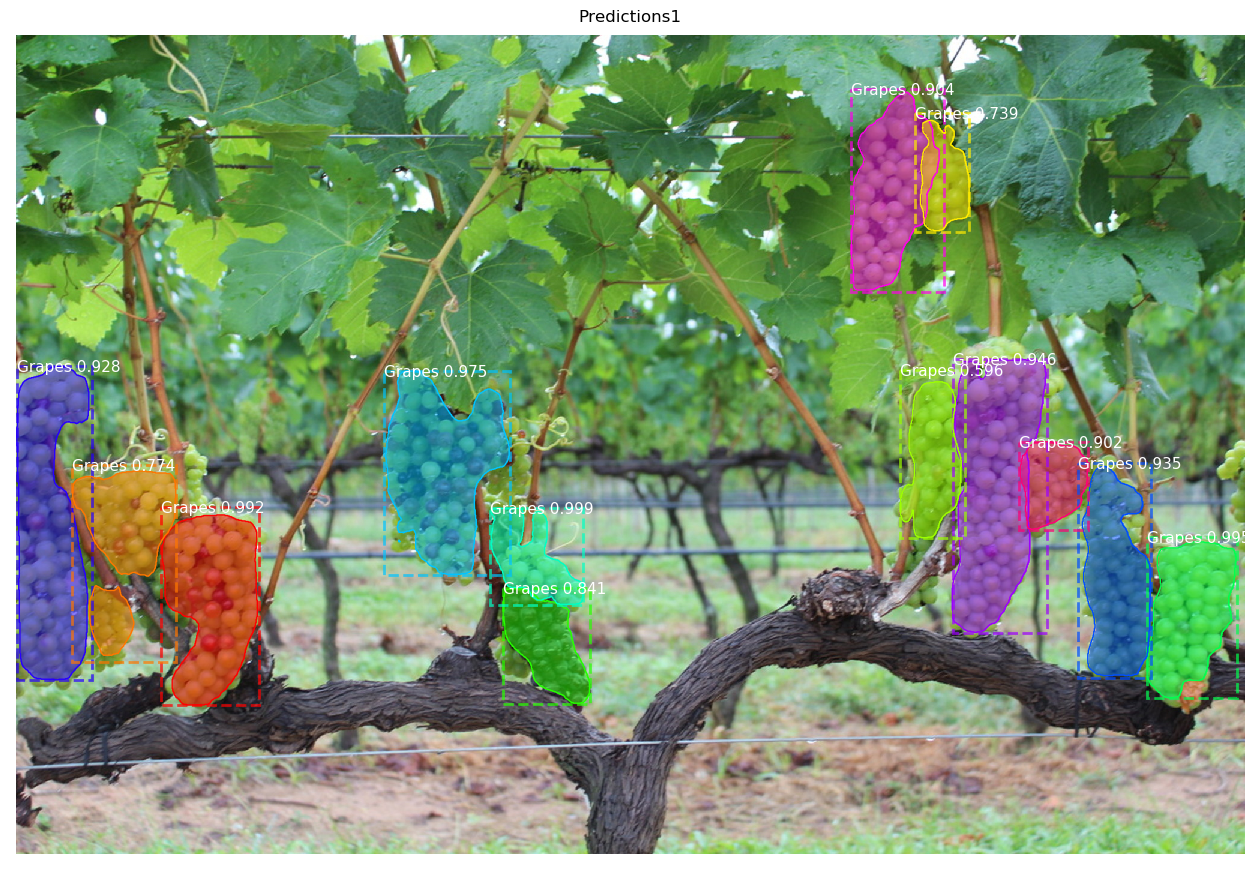

: 

In [37]:
print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

# This is for predicting images which are not present in dataset
path_to_new_image =os.path.join(Path.DS_ImagesPath,"SYH_2017-04-27_1316.jpg")
image1 = mpimg.imread(path_to_new_image)

# Run object detection
#print(len([image1]))
results1 = model.detect([image1], verbose=1)
print(results1)
# Display results
ax = get_ax(1)
r1 = results1[0]
visualize.display_instances(image1, r1['rois'], r1['masks'], r1['class_ids'],
dataset.class_names, convert_scores(r1['scores']), ax=ax, title="Predictions1")

In [11]:
image_id = 32 #random.choice(dataset.image_ids)
#image_id = 'D:/MaskRCNN-aar/Dataset/val/1.jfif'
print("image id is :",image_id)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
modellib.load_image_gt(dataset, config, image_id,use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id,dataset.image_reference(image_id)))

# Run object detection
results = model.detect([image], verbose=1)

image id is : 32
image ID: object.CSV_1898.jpg (32) E:\vsc2.0\GitHub\Grape_instance_segementation_and_masking\PreprocessedDataset\Images\CSV_1898.jpg
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


gt_class_id              shape: (13,)                 min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (13, 4)               min:   59.00000  max:  877.00000  int32
gt_mask                  shape: (1024, 1024, 13)      min:    0.00000  max:    1.00000  float64


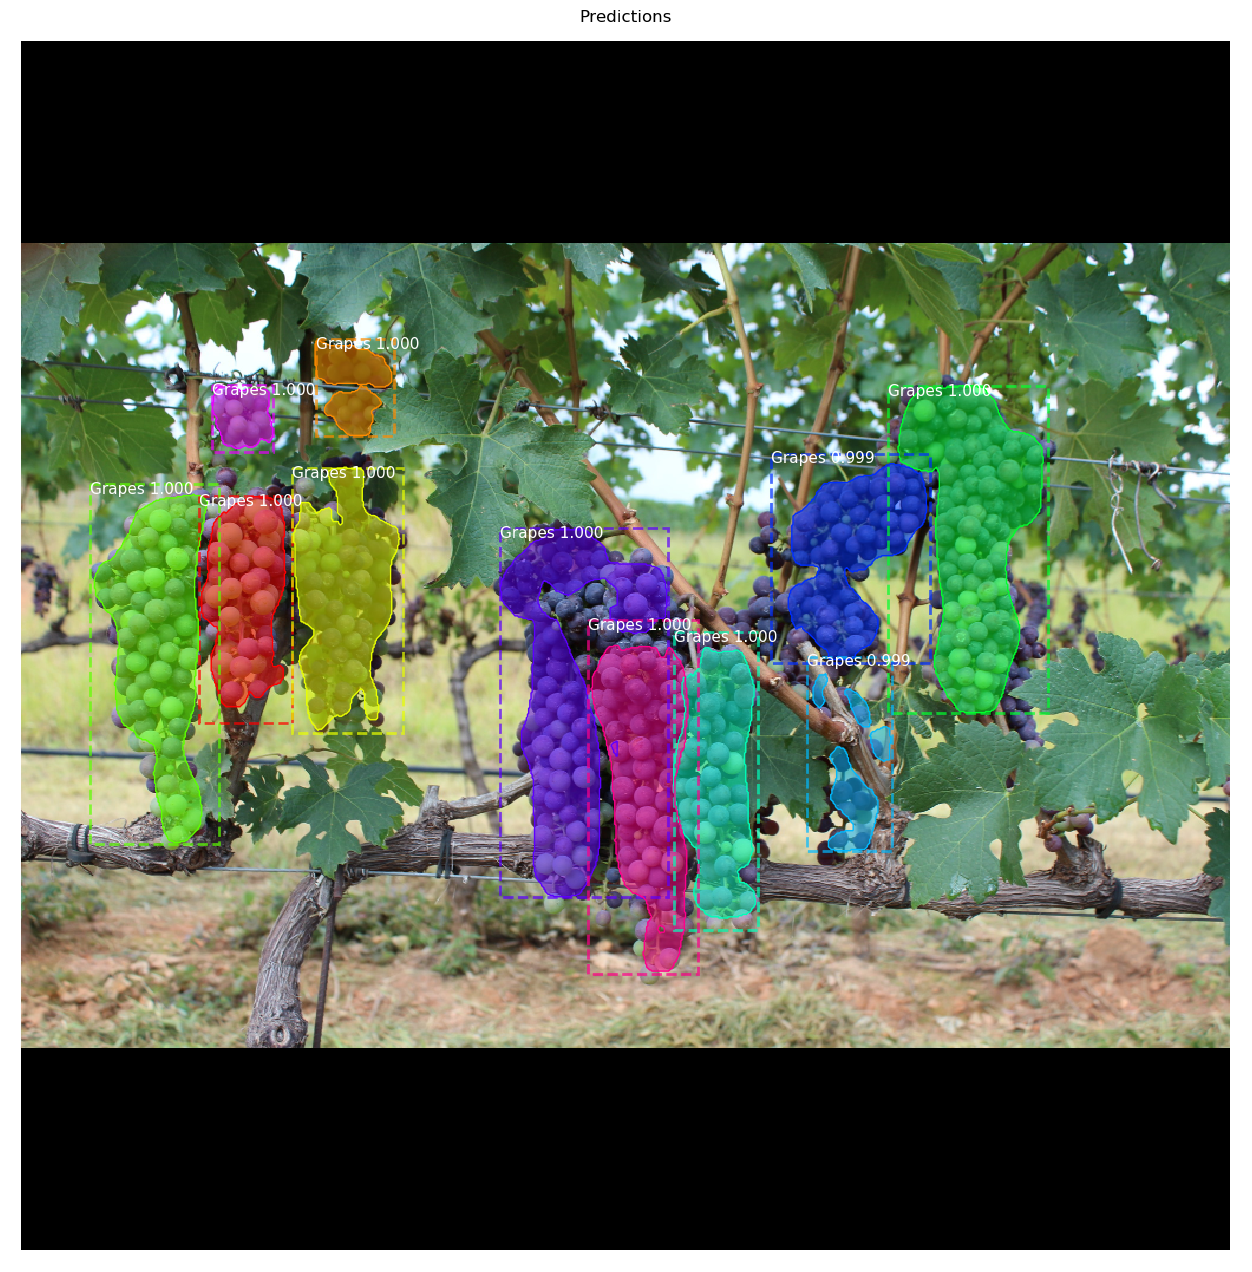

In [12]:
x = get_ax(1)
r = results[0]
ax = plt.gca()
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], dataset.class_names, r['scores'], ax=ax, title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

In [13]:
print(results)

[{'rois': array([[385, 150, 577, 229],
       [361, 229, 586, 323],
       [292, 734, 569, 870],
       [252, 249, 334, 315],
       [375,  58, 680, 167],
       [412, 405, 725, 548],
       [291, 161, 348, 213],
       [500, 553, 753, 624],
       [490, 480, 790, 573],
       [521, 665, 686, 737],
       [349, 635, 526, 770]]), 'class_ids': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), 'scores': array([0.9999963 , 0.99999595, 0.9999919 , 0.99998343, 0.99998283,
       0.9999722 , 0.99993086, 0.99991167, 0.99990964, 0.99909234,
       0.9989127 ], dtype=float32), 'masks': array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [Fa

In [16]:
iou_matrix={}
ground={} #ground masks
prediction={} #predicted masks
ground_boxes={}
ground_conf={}
prediction_boxes={}
prediction_conf={}

ground_ids={}
prediction_ids={}

iou_matrix={}

In [17]:
dsfile=json.load(open(Path.DS_JsonFilePath,'r'))

In [18]:

for file in dsfile['test']:
    gt_truth=np.load(os.path.join(Path.DS_NPZMasksPath,file))
    gt_truth=gt_truth['arr_0']
    # print("Ground Truth Masks Obtained for:",file[:-3])
    # print("Ground Truth Shape:",gt_truth.shape)
    # plt.imshow(gt_truth[:,:,0])

    textFile=open(os.path.join(Path.DS_TextFilesPath,file[:-3]+'txt'),'r')
    gt_boxes=textFile.readlines()
    gt_boxes_=[list(map(float,line.split(' ')))[1:] for line in gt_boxes ]
    gt_conf_=[1]*len(gt_boxes_)
    gt_ids_=gt_conf_

    imgFile=file[:-3]+"jpg"
    print("Image File Detected as:",imgFile)
    image=cv2.imread(os.path.join(Path.DS_ImagesPath,imgFile))
    # print("Image shape:",img.shape)

    

    ground_boxes[imgFile]=gt_boxes_
    ground_conf[imgFile]=gt_conf_
    ground[imgFile]=gt_truth
    ground_ids[imgFile]=gt_ids_
    #print(len(gt_boxes_),"Ground Turth Boxes obtained for:",file[:-3])
    textFile.close()
    # Run the model
    results = model.detect([image], verbose=1)
    r = results[0]
    prediction[imgFile]=r['masks']
    prediction_boxes[imgFile]=r['rois']
    prediction_conf[imgFile]=r['scores']
    prediction_ids[imgFile]=r['class_ids']

    #iou_matrix[key]=MyUtils.compute_IOU_Matrix(gt_mask,r['masks'])
    

Image File Detected as: CSV_20180427_144513954.jpg
Processing 1 images
image                    shape: (1536, 2048, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 2048.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
Image File Detected as: CDY_2015.jpg
Processing 1 images
image                    shape: (1365, 2048, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 2048.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
Image File Detected as: CDY_2017.jpg
Processing 1 images
image                    shape: (1365, 2048, 3)    

In [17]:
#plt.imshow(cv2.cvtColor(cv2.imread(os.path.join(Path.DS_ImagesPath,'CDY_2015.jpg')),cv2.COLOR_BGR2RGB))

In [18]:
#MyUtils.visualise(ground['CDY_2015.jpg'],'CDY_2015.jpg',imgPath=Path.DS_ImagesPath)

In [19]:
#MyUtils.visualise(prediction['CDY_2015.jpg'],'CDY_2015.jpg',Path.DS_ImagesPath)

In [20]:
#MyUtils.visualise_with_boxes(ground['CDY_2015.jpg'],ground_boxes['CDY_2015.jpg'],convert_scores(ground_conf['CDY_2015.jpg']),'CDY_2015.jpg',Path.DS_ImagesPath)

In [19]:
d

In [22]:
#visualise_with_boxes2(prediction['CDY_2015.jpg'],prediction_boxes['CDY_2015.jpg'],prediction_conf['CDY_2015.jpg'],'CDY_2015.jpg',Path.DS_ImagesPath)

In [23]:
#MyUtils.display_instances('CDY_2015.jpg',Path.DS_ImagesPath,np.array(prediction_boxes['CDY_2015.jpg']),prediction['CDY_2015.jpg'],np.array(prediction_ids['CDY_2015.jpg']),["Background","Grapes"],prediction_conf['CDY_2015.jpg'])

In [24]:
# for key in prediction:
#     MyUtils.visualise(prediction[key],key,Path.DS_ImagesPath,Path.SG_MRCNNPredictedImages_Path,True)

In [25]:
#newPath=os.path.join(Path.SegmentatedImages_Path,"MRCNNPredictedImagesWithBoxes2")

In [26]:
#for key in prediction:
#    MyUtils.display_instances(key,Path.DS_ImagesPath,np.array(prediction_boxes[key]),prediction[key],np.array(prediction_ids[key]),["Background","Grapes"],convert_scores(prediction_conf[key]),save=True,save_dir=newPath)

In [27]:
# for key in prediction:
#     visualise_with_boxes2(prediction[key],prediction_boxes[key],convert_scores(prediction_conf[key]),key,Path.DS_ImagesPath,newPath,True)

In [21]:
mAP_list_mrcnn=[]
mAP_list_YOLO=[]
precisions_and_recalls={}
for key in ground:
    img=cv2.imread(os.path.join(Path.DS_ImagesPath,key))
    height,width,_=img.shape
    ground_boxes_=MyUtils.convertYOLO_bb_2_MRCNN_bb(ground_boxes[key],height,width)
    mAP_mrcnn, precisions, recalls, overlaps, precisions_org,recall_org=MyUtils.compute_ap_mrcnn(np.array(ground_boxes_),np.ones((len(ground_boxes[key]))),ground[key],prediction_boxes[key],np.ones((len(prediction_boxes[key]))),prediction_conf[key],prediction[key])
    if mAP_mrcnn<1:
        mAP_YOLO,_,_= MyUtils.compute_ap_yolov8(recall_org,precisions_org)
        mAP_list_mrcnn.append(mAP_mrcnn)
        mAP_list_YOLO.append(mAP_YOLO)
        precisions_and_recalls[key]={'precisions':precisions,'recalls':recalls}
        iou_matrix[key]=overlaps
        
        print("mAP for",key,"is: ",mAP_YOLO)
        print("Average mAP till now is: ",sum(mAP_list_YOLO)/len(mAP_list_YOLO))

mAP for CSV_20180427_144513954.jpg is:  0.8570000054836276
Average mAP till now is:  0.8570000054836276
mAP for CDY_2015.jpg is:  0.829030303030303
Average mAP till now is:  0.8430151542569653
mAP for CDY_2017.jpg is:  0.9281095319021333
Average mAP till now is:  0.8713799468053546
mAP for CDY_2018.jpg is:  0.9613999869823503
Average mAP till now is:  0.8938849568496035
mAP for CDY_20180427_153021423_BURST001.jpg is:  0.958973321183527
Average mAP till now is:  0.9069026297163882
mAP for CDY_20180427_153144437_BURST000_COVER_TOP.jpg is:  0.954500014752154
Average mAP till now is:  0.9148355272223491
mAP for CDY_2028.jpg is:  0.7705403912270303
Average mAP till now is:  0.8942219363658749
mAP for CDY_2034.jpg is:  0.8446372579102422
Average mAP till now is:  0.8880238515589208
mAP for SYH_2017-04-27_1269.jpg is:  0.7549499957546593
Average mAP till now is:  0.8732378675806696
mAP for SYH_2017-04-27_1253.jpg is:  0.9775
Average mAP till now is:  0.8836640808226026
mAP for CSV_1901.jpg is

In [22]:
mIOU=MyUtils.compute_mIOU(iou_matrix)

In [23]:
print(mIOU)

0.6684247104822924


In [24]:
mAP_mrcnn=sum(mAP_list_mrcnn)/len(mAP_list_mrcnn)
mAP_YOLO=sum(mAP_list_YOLO)/len(mAP_list_YOLO)

In [25]:
print(mAP_mrcnn)
print(mAP_YOLO)

0.7906175894846245
0.863195713262265


In [26]:
resultPath=Path.ResultCurvesPath

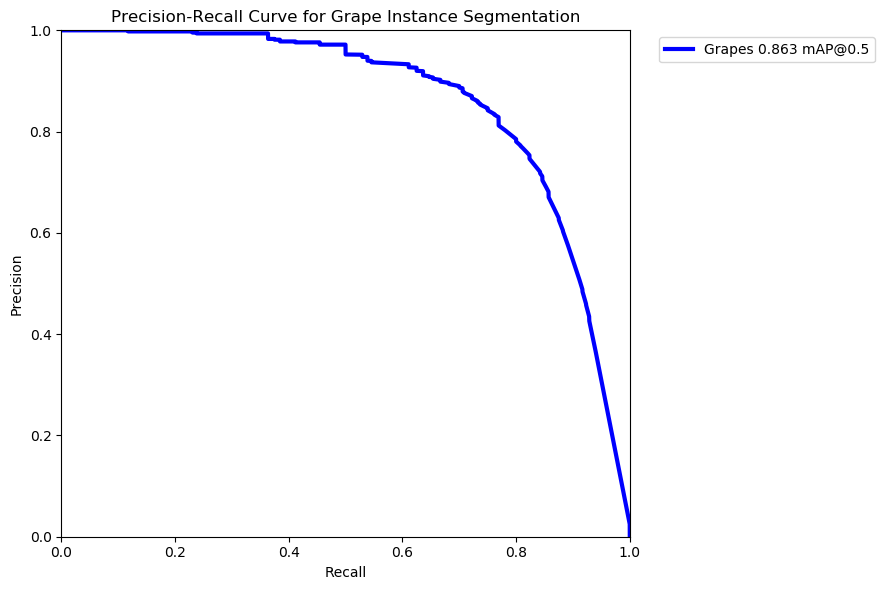

In [27]:
MyUtils.plot_PR_curve(precisions_and_recalls,mAP_YOLO,save=False,save_dir=resultPath,saveFileName="PR_Curve_MRCNN.png")

In [37]:
# for key in ground:
#     prediction_conf[key]=np.max(iou_matrix[key],axis=1)

In [30]:
scores=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
precision_byConfidence={}
recall_byConfidence={}
F1Score_byConfidence={}


AveragePrecision=[]
AverageRecall=[]
AverageF1_Score=[]

for key in ground:
    img=cv2.imread(os.path.join(Path.DS_ImagesPath,key))
    height,width,_=img.shape
    ground_boxes_=MyUtils.convertYOLO_bb_2_MRCNN_bb(ground_boxes[key],height,width)
    precision_for_each_conf=[]
    recall_for_each_conf=[]
    f1_for_each_conf=[]
    mAP_list=[]
   
    for score in scores:
        
        mAP_, _, _,_, precisions_array,recall_array=MyUtils.compute_ap_mrcnn(np.array(ground_boxes_),np.ones((len(ground_boxes_))),ground[key],prediction_boxes[key],np.ones((len(prediction_boxes[key]))),prediction_conf[key],prediction[key],my_score_threshold=score)
        if True:
            mAP_list.append(mAP_)
            if len(precisions_array)>0:
                precision_for_each_conf.append(precisions_array[-1])
            else:
                precision_for_each_conf.append(1)

            if len(recall_array)>0:
                recall_for_each_conf.append(recall_array[-1])
            else:
                recall_for_each_conf.append(0)

       # print(len(recall_for_each_conf))

    for h in range(0,len(precision_for_each_conf)):
            f1_for_each_conf.append( (2*recall_for_each_conf[h]*precision_for_each_conf[h]) / (recall_for_each_conf[h]+precision_for_each_conf[h]) )

    if mAP_list[5]<1:
        print("Precision for",key,":",precision_for_each_conf)
        print("Recall for",key,":",recall_for_each_conf)
        print("F1-Score for",key,":",f1_for_each_conf)

        print()
        x=len(precision_for_each_conf)
        x=x//2
        AveragePrecision.append(precision_for_each_conf[x])
        AverageRecall.append(recall_for_each_conf[x])
        AverageF1_Score.append(f1_for_each_conf[x])


        print("Till now Average Precision:",sum(AveragePrecision)/len(AveragePrecision),"Average Recall:",sum(AverageRecall)/len(AverageRecall),"Average F1-Score:",sum(AverageF1_Score)/len(AverageF1_Score))
        precision_byConfidence[key]=precision_for_each_conf
        recall_byConfidence[key]=recall_for_each_conf
        F1Score_byConfidence[key]=f1_for_each_conf
    print()

Precision for CSV_20180427_144513954.jpg : [0.7692307692307693, 0.7692307692307693, 0.7692307692307693, 0.7692307692307693, 0.7692307692307693, 0.8333333333333334, 0.8333333333333334, 0.8333333333333334, 0.9090909090909091, 1.0, 1]
Recall for CSV_20180427_144513954.jpg : [0.7692308, 0.7692308, 0.7692308, 0.7692308, 0.7692308, 0.7692308, 0.7692308, 0.7692308, 0.7692308, 0.7692308, 0]
F1-Score for CSV_20180427_144513954.jpg : [0.7692307761082283, 0.7692307761082283, 0.7692307761082283, 0.7692307761082283, 0.7692307761082283, 0.8000000074386596, 0.8000000074386596, 0.8000000074386596, 0.8333333414047954, 0.8695652261798908, 0.0]

Till now Average Precision: 0.8333333333333334 Average Recall: 0.7692307829856873 Average F1-Score: 0.8000000074386596

Precision for CDY_2015.jpg : [0.8181818181818182, 0.8181818181818182, 0.8181818181818182, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.9, 0.9, 0.9444444444444444, 1]
Recall for CDY_2015.jpg : [0.75, 0.75, 0.7

In [31]:
AvgPrecision=sum(AveragePrecision)/len(AveragePrecision)
AvgRecall=sum(AverageRecall)/len(AverageRecall)
AvgF1_score=sum(AverageF1_Score)/len(AverageF1_Score)

In [32]:
print("Average Precision:",AvgPrecision)
print("Average Recall:",AvgRecall)
print("Average F1-Score:",AvgF1_score)

Average Precision: 0.8377632096452722
Average Recall: 0.7911433891246193
Average F1-Score: 0.809414744942997


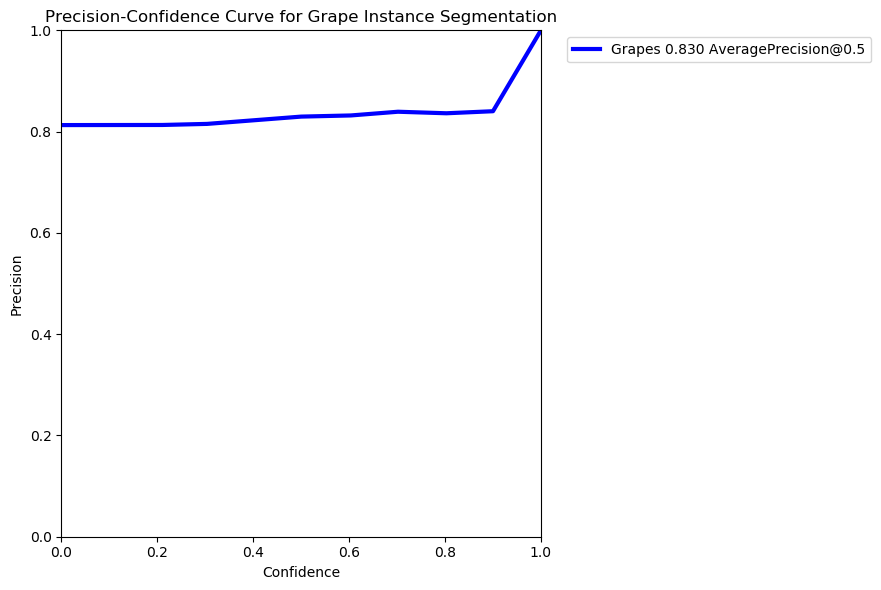

In [43]:
MyUtils.plot_PrecisionConfidence_curve(scores,precision_byConfidence,AvgPrecision,save=False,save_dir=resultPath,saveFileName="PrecisionConfidence_Curve_MRCNN.png")

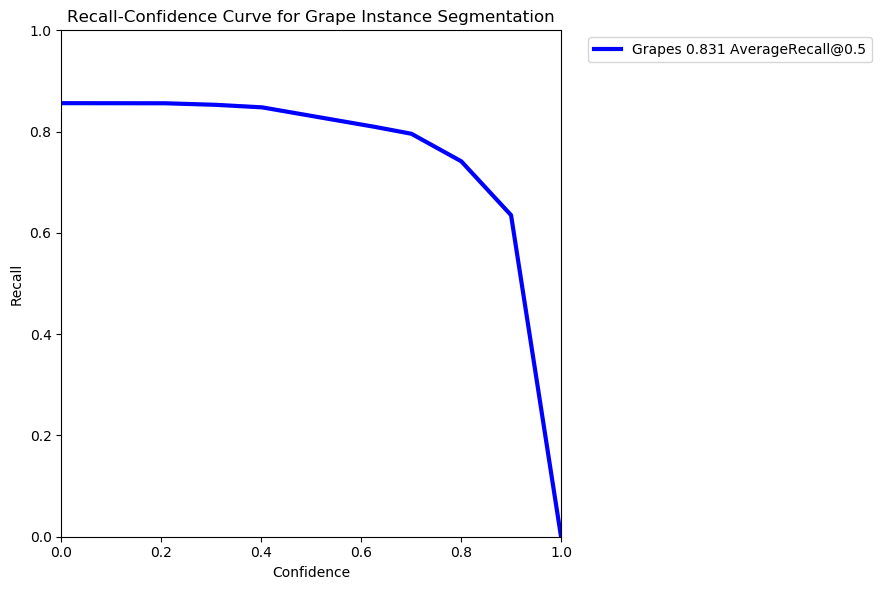

In [44]:
MyUtils.plot_RecallConfidence_curve(scores,recall_byConfidence,AvgRecall,save=False,save_dir=resultPath,saveFileName="RecallConfidence_Curve.png")

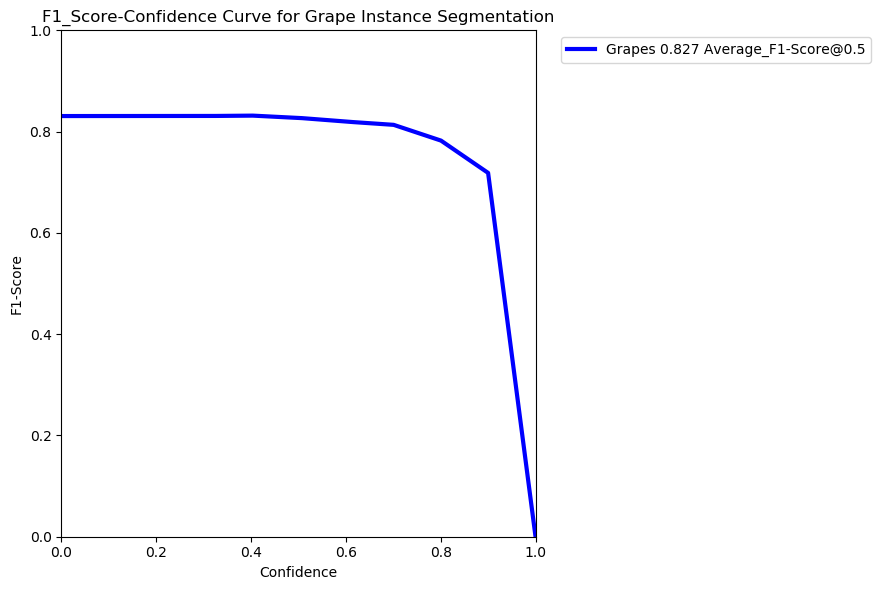

In [45]:
MyUtils.plot_F1ScoreConfidence_curve(scores,F1Score_byConfidence,AvgF1_score,save=False,save_dir=resultPath,saveFileName="F1ScoreConfidence_Curve_MRCNN.png")